Several areas of Earth have large collection of natural resources such as Oil and Salt. Geologist and Scientist believes there is a correlation between oil and gas and salt. Salt naturally get trapped in between rocks and creates a natural structure of large quantity. Geologist also believes finding sizable quantity of slat in an area also increase the prospect of discovering large amount of Oil and Gas, hence many oil and gas companies in the world analyze collect ground image to analyze. But unfortunately, identify salt disposition is very difficult and takes months to analyze the seismic images by professionals. That is where Machine learning has a role to play and identify salt disposition on a sensible fashion while also relying on human professionals. 

Problem Description: There was a competition launch by Kaggle to identify salt in real Seismic Images and collcted from one of the oil and gas company. 

Author: This algorithm is a combined effort of Russell Rupok and Ajibade Shodunke. Two graduate students of Athabasca University and some of the codes came from https://www.kaggle.com/c/tgs-salt-identification-challenge/notebooks written by different authors to modify.


 Method: We will try to build a model which will automatically and accuratly identifies if a subsurface has salt or not.We use few diffirent libraries and methods but major part was developed using Tensforflow and Keras to create a Convolutional Neural Network (CNN) to go through the images and indentify salt and save the image ID number to a .csv file to download.
 
  
 

In [1]:
#Importing libraries. Libraries are divided in to few different parts based on their needs from uploading the image to split them , resize 
# train them ,fit in to the method and finally run the model to find the accuracy.

# Used OS ,Numpy and Pandas to upload the image data and convert them into numerical values and finally pnada's dataframe used to download as .csv

import os
import numpy as np
import pandas as pd


# Seaborn and matplotlib is used to plot the images graphically with its size.

import seaborn as sns
from matplotlib import pyplot as plt

# Bellow libraries are used to work on the image itself and to resize
import imageio
import torch 
from torch.utils import data
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# use sklearn to split the data in data and labels

from sklearn.model_selection import train_test_split

# used Keras to load the model,convert image to numerical value, create CNN and train the model to get higher accuracy
import keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

# keras is backed by tensorflow and one of its primary component of deep learning in python

import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

D:\Anaconda3_5_2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class TGSSaltIdentifyDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_file_path, file_list):
        self.root_file_path = root_file_path
        self.file_list = file_list
   
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
   
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_file_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_file_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask



In [3]:
#train image + mask data from local drive which in this case is D where train.csv and depths.csv is located
training_mask = pd.read_csv('D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/train.csv')

#uploading depth data. Using pandas read_csv method to uplaod the data from a specific location in the computer D drive.
# depending on the personal preference location could change of the dataset
depth = pd.read_csv('D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/depths.csv')

#uploading training path from D drive 
train_path = "D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/train/"

#Creating list of files using python's dictonary to get the ID values
file_list = list(training_mask['id'].values)

#define our dataset using our class TGSSaltIdentifyDataset 

SaltImagedataset = TGSSaltIdentifyDataset(train_path, file_list) 

In [4]:
#Create function to visualize these 2X2 images coming in from dataset to 1 row and 2 column subplot of image and mask
def plotting2x2Array_ImageMask(image, mask):
    
    #Use  matplotlib
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('IMAGE') # set title of image 
    axarr[1].set_title('MASK')  # set title of MASK

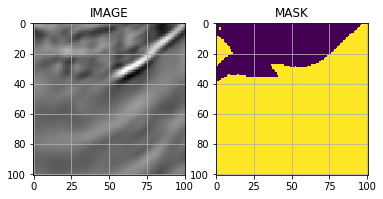

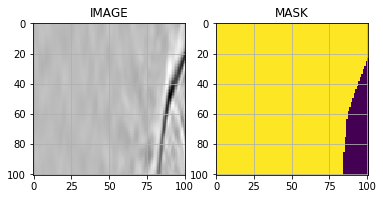

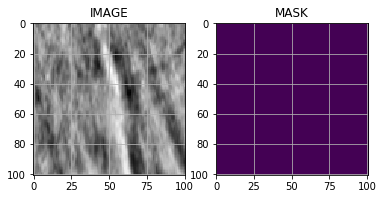

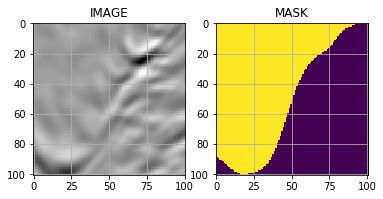

In [5]:
# loop over image and mask from the data set coming in from SaltImagedataset. 
# Len() method helps to loop over all the data dataset has than specifing a specific range
for x in range(4):
    image, mask = SaltImagedataset[np.random.randint(len(SaltImagedataset))]
    plotting2x2Array_ImageMask(image, mask)

D:\Anaconda3_5_2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Depth')

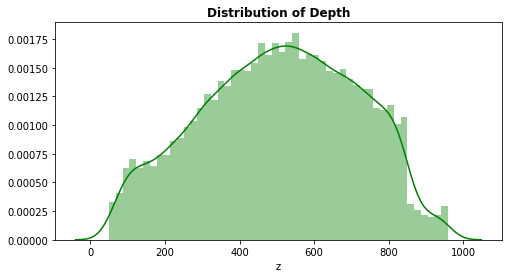

In [6]:
# use matplot to create 8 by 4 histogram to see the spread of the depth 
plt.figure(figsize = (8, 4))
#plt.hist(depth['z'], bins = 50,color='red')
sns.distplot(depth['z'], bins = 50,color='green')

plt.title('Distribution of Depth',fontweight='bold')



In [7]:
#Create rleToMask function to convert to image with specific height and width
def rleToMask(rleString,height,width):
    #width heigh assignment
    rows=height
    cols=width
    # use python try method to catch any error 
    try:
        #Covert to int datatype get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #Use Numpy to create an image using datatype uint8.
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for loop to loop over each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #use reshape () to reshape the colums and rows 
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [8]:
# Createing function salt_proportion() to measure how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=False) #sorted unique elements of an array.
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201. 
    
    except: 
        #return 0.0
        return 0

In [9]:
# merging all the depth to the left and showing first 10 from the data set with ID number 
merging_depth = training_mask.merge(depth, how = 'left')
merging_depth.head(10)

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797
5,782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...,677
6,9842f69f8d,NaN,907
7,aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...,754
8,50d3073821,1 2121 9293 909,810
9,28f865caaa,NaN,147


In [10]:
# splitting dataset into train and test with the width and depth of 128*128 
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
path_train = 'D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/train/'
path_test = 'D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/test/'

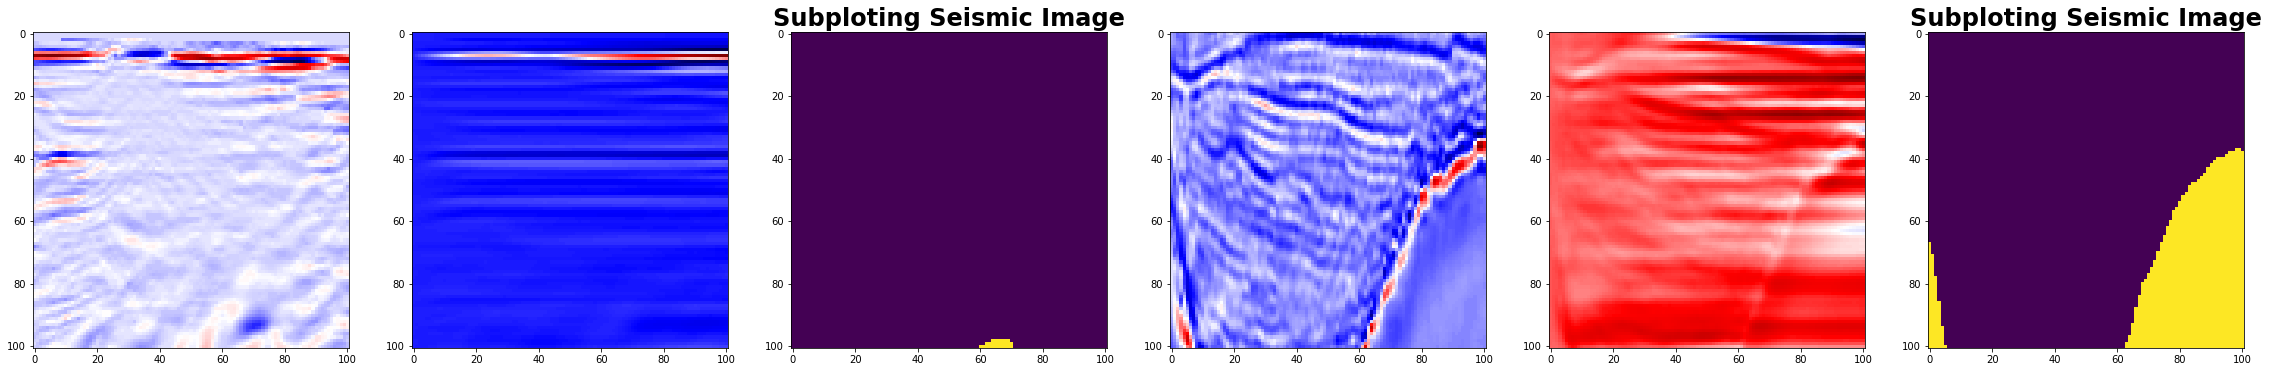

In [11]:
# Selecting ID's from Image ad Mask Dataset and loading them to create subplot using Matplotlib
ids= ['0ddcd3fd1a','5b7c160d0d']
plt.figure(figsize=(60,30))
for j, img_name in enumerate(ids):
    #q = j+1
    k = j+1
    img = load_img('D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/train/images/' + img_name + '.png', grayscale=True)
    img_mask = load_img('D:/MSc/COMP657/TMA3/tgs-salt-identification-challenge/train/masks/' + img_name + '.png', grayscale=True)
    
    img = np.array(img)
    img_cumsum = (np.float64(img)-img.mean()).cumsum(axis=1)
    img_mask = np.array(img_mask)
    
    plt.subplot(3,3*(1+len(ids)),k*3-2)
   
    plt.imshow(img, cmap='seismic')
    plt.subplot(3,3*(1+len(ids)),k*3-1)
    plt.imshow(img_cumsum, cmap='seismic')
    plt.subplot(3,3*(1+len(ids)),k*3)
    plt.imshow(img_mask)
    plt.title('Subploting Seismic Image',fontweight='bold',size=24)
    
plt.show()



In [12]:
#walk() generates the file names in a directory tree by walking the tree either top-down or bottom-up.
Datatrain_ids = next(os.walk(path_train+"images"))[2]
Datatest_ids = next(os.walk(path_test+"images"))[2]

In [13]:
import sys 
# Get and resize train images and masks
X_train = np.zeros((len(Datatrain_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(Datatrain_ids), im_height, im_width, 1), dtype=np.bool)
print('Loading  and resizing train Data images and masks ... ')

#sys.stdout.flush() forces Data to "flush" the buffer
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(Datatrain_ids), total=len(Datatrain_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True) # create concrete function in tensorflow to get semantic segmentation image and calculate co-ordinates.
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('We are done resizing Image')

Loading  and resizing train Data images and masks ... 


D:\Anaconda3_5_2\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



We are done resizing Image


**Model training **

In [14]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int64(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

**Building U-Net (CNN) Model**

In [15]:
# Build U-Net model which is top down approch and connecting each layer to the nexe one using lambda function.
#Used Activation function relu(rectified linear activation) so it can sum weighted input from the node into the activation of the node or output for that input.

inputs = Input((im_height, im_width, im_chan)) # Getting the input
s = Lambda(lambda x: x / 255) (inputs) # used lambda to go over all the input

c1 = Conv2D(16, (3, 3), activation='relu',strides=(1, 1), padding='same') (s) # we learn a total of 16 filters used as Dense
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)  #Relu function is a piecewise linear function 
p1 = MaxPooling2D((2, 2)) (c1) #Max pooling is then used to reduce the spatial dimensions of the output volume.

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1) # we learn a total of 32 filters
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2) #Padding=same means preserve the spatial dimensions of the volume 
p2 = MaxPooling2D((2, 2)) (c2) #Max pooling is then used to reduce the spatial dimensions of the output volume.

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2) # we learn a total of 64 filters
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3) 
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3) # we learn a total of 128 filters
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4) #Max pooling is then used to reduce the spatial dimensions of the output volume.

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4) # we learn a total of 256 filters
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5) # Transposed convolution layer(sometimes called Deconvolution)
u6 = concatenate([u6, c4]) # Join u6 and c4 values
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9) # Creating out put layer with 1 filter

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou]) # Compiling model with loos function and optimizer
print("Printing Model Summary Bellow")
model.summary() #Summary of the model bellow

Printing Model Summary Bellow
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 304         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
_______________________________________________________________________________

In [16]:
# Used batch_size 20 meaning it will get last 20 sample at a time with epochs 2 ( run over the whole sample one time) to keep it simple
# Epocs and batch size can change to other numerical value but will take time to run the model
# GPU is prefered but CPU willdo the work as well
# More epoch will increase the performance of the model and accuracy rate while having less loss in the next cycle

callback = EarlyStopping(patience=10, verbose=1) # Creating Callback function for early stopping if the val_loss does not impove
checkpointer = ModelCheckpoint('model_tgssalt_identify.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=20, epochs=2, # using fit() method to fit the data and labels
                    callbacks=[callback, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/2
3600/3600 [==============================] - 288s 80ms/step - loss: 0.5599 - mean_iou: 0.3776 - val_loss: 0.5141 - val_mean_iou: 0.3774

Epoch 00001: val_loss improved from inf to 0.51410, saving model to model_tgssalt_identify.h5
Epoch 2/2
3600/3600 [==============================] - 312s 87ms/step - loss: 0.5046 - mean_iou: 0.3781 - val_loss: 0.3917 - val_mean_iou: 0.3885

Epoch 00002: val_loss improved from 0.51410 to 0.39168, saving model to model_tgssalt_identify.h5


In [17]:
# Get and resize test images
X_test = np.zeros((len(Datatest_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Loading and resizing test images to 128*128*1 format... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(Datatest_ids), total=len(Datatest_ids)): # looping over Datatest_ids
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True) # resizing the image
    X_test[n] = x

print('We are done with resizing Images!!')



Loading and resizing test images to 128*128*1 format... 


D:\Anaconda3_5_2\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



We are done with resizing Images!!


In [18]:
# Predict on train, val and test
#loading the model from previous step
model = load_model('model_tgssalt_identify.h5', custom_objects={'mean_iou': mean_iou}) 
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=2)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=2)
preds_test = model.predict(X_test, verbose=2)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [19]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    

preds_test_upsampled[0].shape

D:\Anaconda3_5_2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


(101, 101)

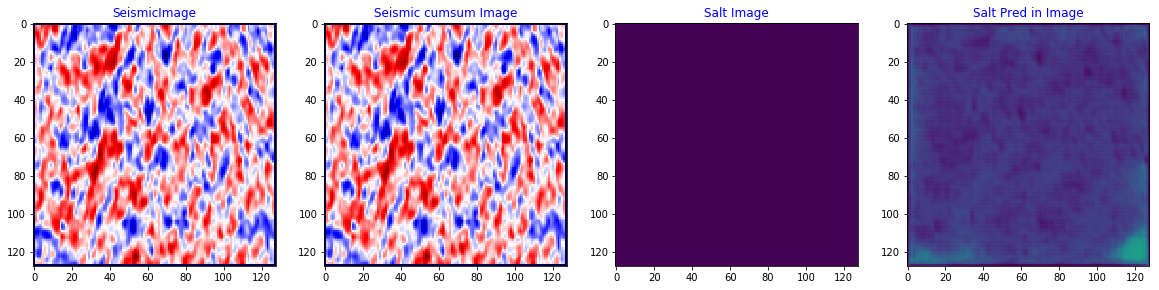

In [20]:
# importing random mathmetical library and creating plot_sample functions
import random 
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 20)) # subploting in 1 row and 4 columns combination
    ax[0].imshow(X[ix, ..., 0], cmap='seismic') # cmap to map scalar data to colors
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('SeismicImage',color='blue')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic cumsum Image',color='blue')

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Salt Image',color='blue')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Pred in Image',color='blue');
    
    

# Check if training data looks all right
plot_sample(X_train, Y_train, preds_train)


In [21]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

**Preparing submission**

In [22]:
# reating RLenc function 
# image is binary mask, order down than right ( fortran), format determins if the order needs to run,if True it will run

def RLenc(img, order='F', format=True):
    
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(Datatest_ids))}

D:\Anaconda3_5_2\lib\site-packages\ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [23]:
# uisng pandas Dataframe to load the data and saving as CSV file to downlaod
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['IMAGE_IDS']
sub.columns = ['RLE_MASK']
sub.to_csv('SaltDisposion_ID_Mask.csv')
print ('Submitted to output and Download as CSV')

Submitted to output and Download as CSV
